# Project Title: Coffee Price Prediction Analysis

## Introduction
This notebook aims to analyze historical coffee price indices and develop a predictive model for future price trends. The focus is on using data from the ICO (International Coffee Organization), particularly indices like I-CIP, Colombian Milds, Other Milds, Brazilian Naturals, and Robustas.

### Objectives:
1. Clean and preprocess the dataset for missing values and inconsistencies.
2. Explore the time-series behavior of coffee prices through visualizations.
3. Implement various forecasting models to predict future price trends.
4. Compare model performance using key metrics (e.g., RMSE, MAE).

### Dataset:
The dataset used in this analysis consists of historical coffee price data, with daily observations for business days. Prices are expressed in cents of USD.

### Tools & Libraries:
- **Python**: For data manipulation and model building.
- **Pandas**: For data handling and preprocessing.
- **Matplotlib & Plotly**: For visualizations.
- **Scikit-learn & Statsmodels**: For predictive modeling.

### Expected Outcome:
By the end of this notebook, we will identify the best forecasting model for coffee prices and present actionable insights based on the findings.

In [18]:
# Import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Loading data
Using dataframe with pre-processed data on separate Jupyter Notebook


433 rows containing original prices, standardised prices, normalised, differentiated values and 4 time-based features (DayOfWeek	|WeekOfYear	|Month	|Quarter)

In [3]:
df = pd.read_csv('processed_data.csv', index_col='date', parse_dates=True)

In [5]:
df

,I-CIP,price_standardized,price_normalized,price_diff,I-CIP_Standardised,DayOfWeek,WeekOfYear,Month,Quarter
date,,,,,,,,,
2023-02-02,172.50,-0.482921,0.209218,1.07,0.209218,3,5,2,1
2023-02-03,169.47,-0.578568,0.185305,-3.03,0.185305,4,5,2,1
2023-02-06,171.29,-0.521117,0.199669,1.82,0.199669,0,6,2,1
2023-02-07,172.14,-0.494285,0.206377,0.85,0.206377,1,6,2,1
2023-02-08,171.23,-0.523011,0.199195,-0.91,0.199195,2,6,2,1
...,...,...,...,...,...,...,...,...,...
2024-09-24,269.83,2.589469,0.977350,3.05,0.977350,1,39,9,3
2024-09-25,270.09,2.597677,0.979402,0.26,0.979402,2,39,9,3
2024-09-26,272.70,2.680066,1.000000,2.61,1.000000,3,39,9,3


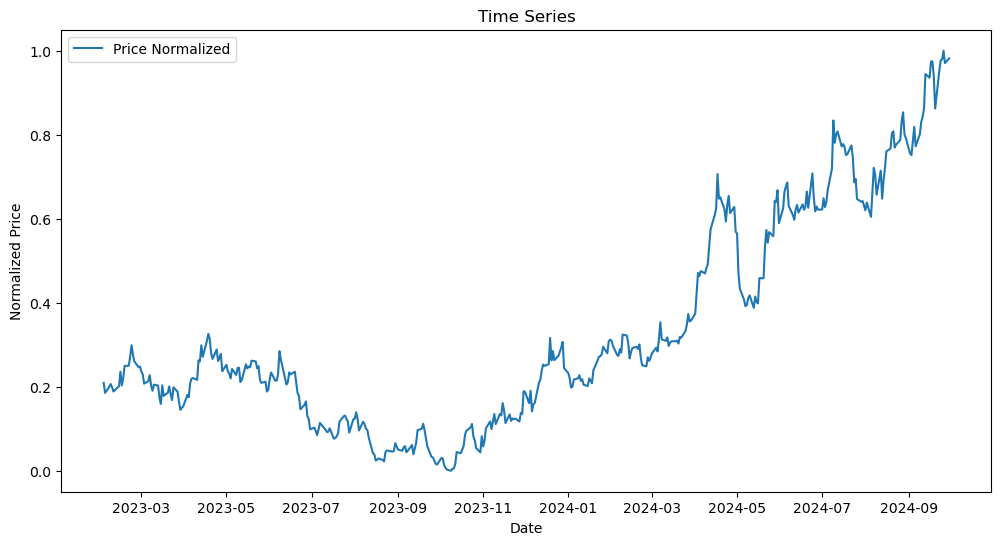

In [6]:
# Select the target column for time series analysis
target_col = 'price_normalized'

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df[target_col], label='Price Normalized')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## 2. Data prep for SARIMA


### 2.1 Cheking for stationarity
 for both normalised data (will mantain data structure, but only in a smaller scale from 0 to 1) and diff values

In [7]:
# ADF Test for Stationarity
result = adfuller(df[target_col])
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Test Statistic: 1.6593577893936908
p-value: 0.9980251657535798
Critical Values: {'1%': -3.446205926287236, '5%': -2.8685297226414734, '10%': -2.570493298011322}


In [11]:
# Select the differentiated column for SARIMA
df_sarima = df[['price_diff']]

#### Shapiro-Wilk test for normality of diff_prices


In [28]:
from scipy.stats import shapiro

def check_normality(series):
    stat, p_value = shapiro(series)
    print(f'Shapiro-Wilk Test Statistic: {stat}')
    print(f'p-value: {p_value}')

    if p_value < 0.05:
        print("The data does not appear to be normally distributed.")
    else:
        print("The data appears to be normally distributed.")

# Example usage:
check_normality(df_sarima)

Shapiro-Wilk Test Statistic: 0.9792444109916687
p-value: 7.385493972833501e-06
The data does not appear to be normally distributed.


In [30]:
# checkin stationarity for diff prices
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

check_stationarity(df_sarima)


ADF Statistic: -7.472991901655821
p-value: 4.997709416514464e-11
Critical Value 1%: -3.445757604526768
Critical Value 5%: -2.8683325885102855
Critical Value 10%: -2.5703882165206853


In [16]:


# Drop NaN values caused by differentiation (from 434 to 433 total obs)
df_sarima = df_sarima.dropna()

# Display the cleaned data
print(df_sarima.head())

            price_diff
date                  
2023-02-02        1.07
2023-02-03       -3.03
2023-02-06        1.82
2023-02-07        0.85
2023-02-08       -0.91


In [23]:
df_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 2023-02-02 to 2024-09-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_diff  433 non-null    float64
dtypes: float64(1)
memory usage: 6.8 KB


Checking Differentiated prices time series shape


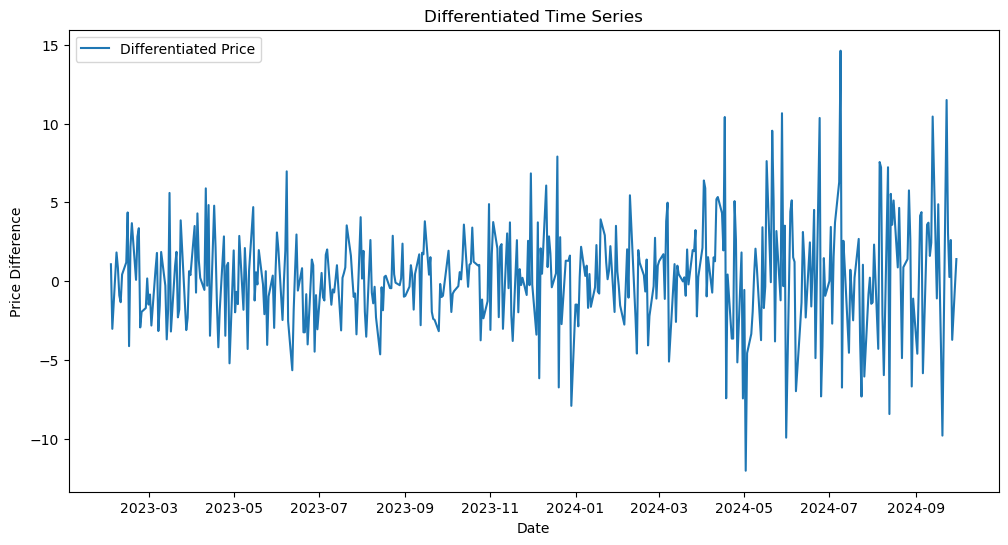

In [17]:
# Plot the differentiated series
plt.figure(figsize=(12, 6))
plt.plot(df_sarima, label='Differentiated Price')
plt.title('Differentiated Time Series')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [ ]:
#acf plot for correlation
plot_acf(price_diff_df.dropna())
plt.show()

# partial correlation 
plot_pacf(price_diff_df.dropna())
plt.show()

 Continuing dictionary to store all metrics from the future modeling

In [21]:
# Initialise a dictionary to store error metrics
model_results = {}

# Function to add new results to the dictionary
def add_model_results(model_name, mse, mae, rmse, mape):
    """
    Adds model performance metrics to the results dictionary.
    """
    model_results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Example: Adding a placeholder for Linear Regression results
add_model_results("Linear Regression", mse=0.0037, mae=0.0469, rmse=0.0612, mape=6.25)

# Print the initial dictionary
print("Initial Model Results:")
print(model_results)

Initial Model Results:
{'Linear Regression': {'MSE': 0.0037, 'MAE': 0.0469, 'RMSE': 0.0612, 'MAPE': 6.25}}


In [22]:
df_sarima

,price_diff
date,
2023-02-02,1.07
2023-02-03,-3.03
2023-02-06,1.82
2023-02-07,0.85
2023-02-08,-0.91
...,...
2024-09-24,3.05
2024-09-25,0.26
2024-09-26,2.61


### 2.2 Splitting Train-Test for SARIMA

SARIMA models require preserving the temporal order of the time series, however, since they are models specific made for capturing seasonality, there is no exaclty need to create a timeseries sequence. At first experimentation, will use a ratio for 80% training and 20% testing



as SARIMA handles the temporal structure internally.

In [24]:
# Define train-test split ratio
train_ratio = 0.8
train_size = int(len(df_sarima) * train_ratio)

# Split into train and test sets
train_data = df_sarima.iloc[:train_size]
test_data = df_sarima.iloc[train_size:]

# Print sizes
print(f"Training Set Size: {len(train_data)}")
print(f"Testing Set Size: {len(test_data)}")

Training Set Size: 346
Testing Set Size: 87


### 2.3 Fit SARIMA 


In [25]:
# Fit SARIMA model on training data
model = SARIMAX(train_data, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 5))
sarima_result = model.fit()

# Print model summary
print(sarima_result.summary())

/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/clarissacardoso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66889D+00    |proj g|=  8.46609D-02

At iterate    5    f=  2.49484D+00    |proj g|=  2.95639D-02

At iterate   10    f=  2.47862D+00    |proj g|=  1.44167D-02

At iterate   15    f=  2.47159D+00    |proj g|=  3.80449D-03

At iterate   20    f=  2.47121D+00    |proj g|=  2.43148D-03

At iterate   25    f=  2.47118D+00    |proj g|=  2.76654D-04

At iterate   30    f=  2.47118D+00    |proj g|=  2.35988D-05

At iterate   35    f=  2.47118D+00    |proj g|=  3.21343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


### 2.4 Forecast and evaluate


In [26]:
# Forecast on the test set
forecast = sarima_result.forecast(steps=len(test_data))

# Calculate error metrics
mse_sarima = mean_squared_error(test_data, forecast)
mae_sarima = mean_absolute_error(test_data, forecast)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test_data.values.flatten() - forecast) / test_data.values.flatten())) * 100

# Print metrics
print(f"SARIMA Performance:\nMSE: {mse_sarima:.4f}\nMAE: {mae_sarima:.4f}\nRMSE: {rmse_sarima:.4f}\nMAPE: {mape_sarima:.2f}%")

# Add metrics to the dictionary
add_model_results("SARIMA", mse=mse_sarima, mae=mae_sarima, rmse=rmse_sarima, mape=mape_sarima)

SARIMA Performance:
MSE: 22.0944
MAE: 3.6516
RMSE: 4.7005
MAPE: inf%


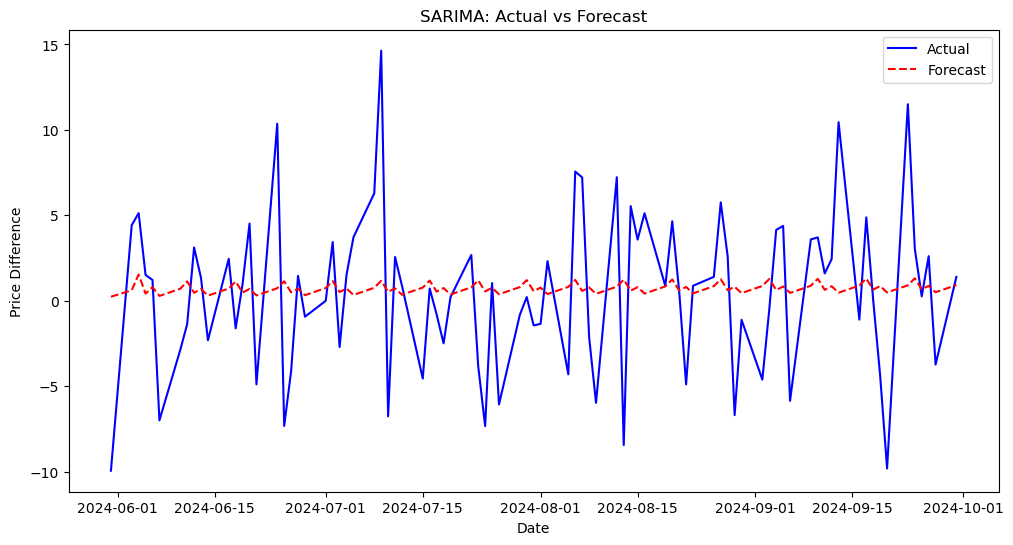

In [27]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('SARIMA: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()
